## Описание проекта
Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

## Описание данных
Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


## Импорт библиотек

In [100]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth

import datetime
from datetime import datetime, date, time

import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

## Изучение и предобработка данных

In [101]:
df = pd.read_csv('/Users/alena/Desktop/projects/AB_project/logs_exp.csv', sep ='\t')
df.head(3)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


### Переименуем столбцы:

In [102]:
df = df.rename(columns = {'EventName':'event_name',
                          'DeviceIDHash':'device_id',
                          'EventTimestamp':'event_timestamp',
                          'ExpId':'exp_id'})
df.head(3)

,event_name,device_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


### Типы данных

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id        244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Пропуски и дубликаты

In [104]:
df.isna().sum()

event_name         0
device_id          0
event_timestamp    0
exp_id             0
dtype: int64

In [105]:
df.duplicated().sum()

413

In [106]:
df_new = df[df.duplicated()].head()
df_new.query('device_id == 5613408041324010552')

,event_name,device_id,event_timestamp,exp_id
453,MainScreenAppear,5613408041324010552,1564474784,248


In [107]:
df.query('device_id == 5613408041324010552 and event_timestamp ==1564474784')

,event_name,device_id,event_timestamp,exp_id
452,MainScreenAppear,5613408041324010552,1564474784,248
453,MainScreenAppear,5613408041324010552,1564474784,248


In [108]:
df = df.drop_duplicates()

Дубликаты могут быть связаны с какой-то технической ошибкой - логи в одно время уходят дважды. Удаляем их.

### Даты

Добавим столбец даты и времени:

In [109]:
df['time'] = pd.to_datetime(df['event_timestamp'], unit = 's')

Добавим столбец даты:

In [110]:
df['date'] = df['time'].dt.date

In [111]:
df.head()

,event_name,device_id,event_timestamp,exp_id,time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


### Вывод
- изменены названия столбцов
- изменен тип данных столбца с датой
- пропусков не обнаружено
- удалены дубликаты
- добавлены два столбца: с датой, с датой и временем

## Проверка данных

### Сколько событий в логе:

In [112]:
len_before = len(df)
len_before

243713

### Сколько всего пользователей в логе:

In [113]:
users_before = df.groupby('device_id').agg({'device_id':'nunique'})['device_id'].sum()
users_before

7551

### Сколько в среднем событий приходится на пользователя:

In [114]:
df.head()

,event_name,device_id,event_timestamp,exp_id,time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [115]:
df_timestamp = df.groupby('device_id').agg({'event_timestamp':'count'}).reset_index()

df_timestamp['event_timestamp'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_timestamp, dtype: float64

32 события на пользователя - это не много, так событие != заход на сайт.
За одну сессию пользователь может совершить хоть 2, хоть 32 события

### Определим период событий, найдем максимальную и минимальную дату

In [116]:
df.date.max() 

datetime.date(2019, 8, 7)

In [117]:
df.date.min()

datetime.date(2019, 7, 25)

Text(0.5, 1.0, 'Гистограмма по дате')

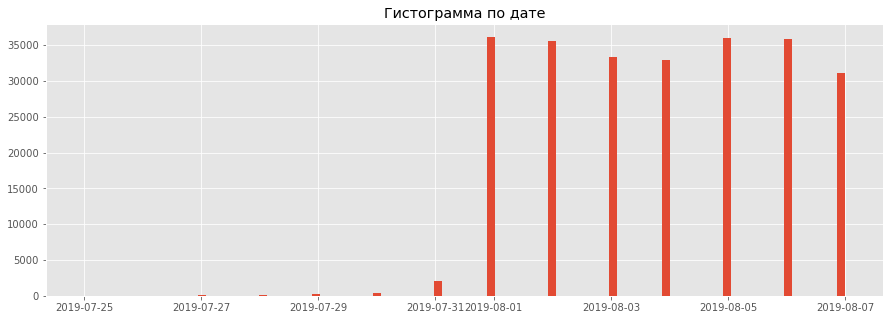

In [118]:
df['date'].hist(bins = 100, figsize = (15,5))

plt.title('Гистограмма по дате')

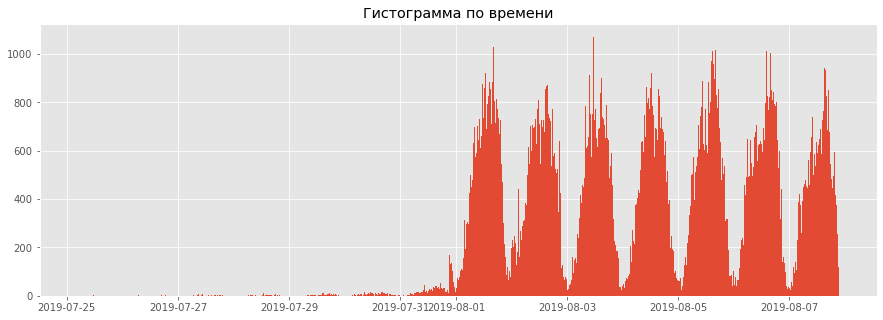

In [119]:
df['time'].hist(bins = 1000, figsize = (15,5))

plt.title('Гистограмма по времени')

plt.show()

Фактически мы располагаем данными за период с 1 августа по 7 августа.

### Удалим неполные данные ранее 1 августа:

In [120]:
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] > '2019-07-31']
df.head()

,event_name,device_id,event_timestamp,exp_id,time,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [121]:
len_after = len(df)
len_after

240887

In [122]:
#Кол-во пользователей после удаления
users_after = df.groupby('device_id').agg({'device_id':'nunique'})['device_id'].sum()
users_after

7534

In [123]:
print('Было удалено строк:', (len_before - len_after))
print('Было удалено строк в %:', ((len_before - len_after)/len_before)*100)

print()

print('Было удалено пользователей:', (users_before - users_after))
print('Было удалено пользователей в %:', ((users_before - users_after)/users_before)*100)

Было удалено строк: 2826
Было удалено строк в %: 1.159560630741897

Было удалено пользователей: 17
Было удалено пользователей в %: 0.22513574361011784


### Проверим, что у нас есть пользователи из всех экспериментальных групп:

Для удобства переименуем группы:

In [124]:
df.exp_id = df.exp_id.replace(246,'A1')
df.exp_id = df.exp_id.replace(247,'A2')
df.exp_id = df.exp_id.replace(248,'B')

Количество пользователей по группам:

In [125]:
df.groupby('exp_id', as_index=False).agg({'device_id':'nunique'})

,exp_id,device_id
0,A1,2484
1,A2,2513
2,B,2537


### Вывод
- Изначально в логе 244 126 событий, данные 7551 пользователей
- В среднем на одного пользователя приходится 32 события, медианное значение - 20 событий
- Представлены данные с 25.07.19 по 07.08.19, c  25.07.19 по 31.07.19 данные неполные
- Фактически мы располагаем данными за период с 1 августа по 7 августа 2019 года
- После очистки данных было удалено 0,32% строк, 0.12% уникальных пользователей
- Присутствуют все 3 группы, число пользователей в группах примерно одинаковое.

## Воронка событий

### Какие события есть в логах, как часто они встречаются

In [126]:
df.head()

,event_name,device_id,event_timestamp,exp_id,time,date
2828,Tutorial,3737462046622621720,1564618048,A1,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,A1,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,A1,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,A1,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,A2,2019-08-01 00:08:59,2019-08-01


In [127]:
df_event_amount = df.groupby('event_name').agg({'event_name':'count'})\
        .rename(columns = {'event_name':'event_counted'})\
        .sort_values(by = 'event_counted', ascending = False)\
        .reset_index()
df_event_amount

,event_name,event_counted
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


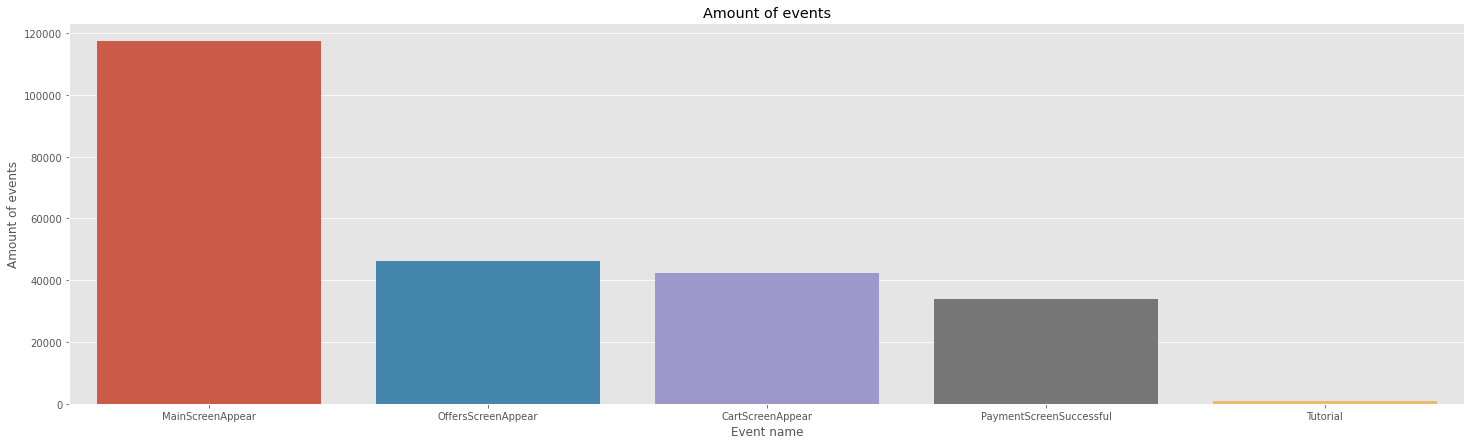

In [128]:
plt.style.use('ggplot')
plt.figure(figsize=(25, 7))  
sns.barplot(x='event_name', y='event_counted', data=df_event_amount)

plt.title('Amount of events')
plt.xlabel('Event name')
plt.ylabel('Amount of events')
plt.show()

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей.

In [129]:
df_users_event = df.groupby('event_name').agg({'device_id':'nunique'})\
        .rename(columns = {'device_id':'users_counted'})\
        .sort_values(by = 'users_counted', ascending = False)\
        .reset_index()

df_users_event

,event_name,users_counted
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


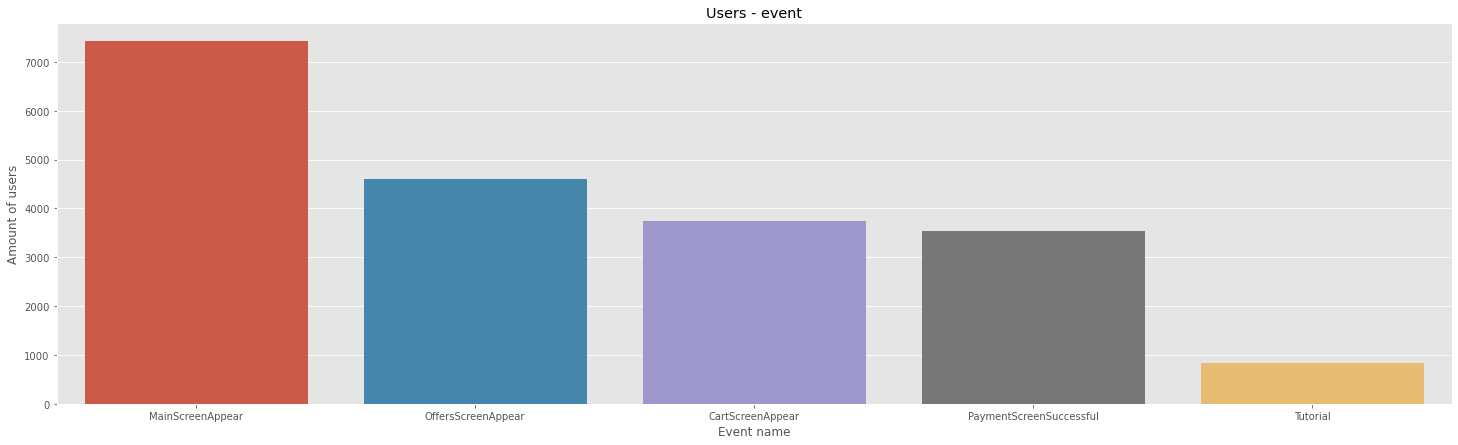

In [130]:
plt.figure(figsize=(25, 7))  
sns.barplot(x='event_name', y='users_counted', data=df_users_event)

plt.title('Users - event')
plt.xlabel('Event name')
plt.ylabel('Amount of users')
plt.show()

### Посчитайте долю пользователей, которые хоть раз совершали событие.

Уникальные пользователи каждого шага/общее число уникумов.

In [131]:
users_after

7534

In [132]:
df_users_event.head()

,event_name,users_counted
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [133]:
df_users_event['unique_users_total'] = users_after
df_users_event['percentage'] = df_users_event['users_counted']/df_users_event['unique_users_total']
df_users_event

,event_name,users_counted,unique_users_total,percentage
0,MainScreenAppear,7419,7534,0.984736
1,OffersScreenAppear,4593,7534,0.609636
2,CartScreenAppear,3734,7534,0.495620
3,PaymentScreenSuccessful,3539,7534,0.469737
4,Tutorial,840,7534,0.111495


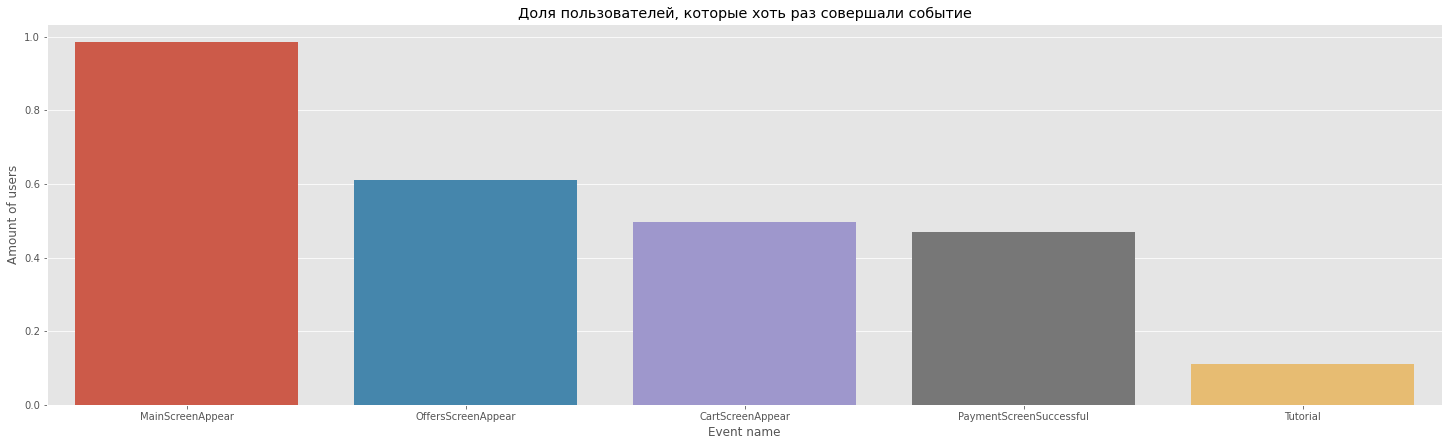

In [134]:
plt.figure(figsize=(25, 7))  
sns.barplot(x='event_name', y='percentage', data=df_users_event)

plt.title('Доля пользователей, которые хоть раз совершали событие')
plt.xlabel('Event name')
plt.ylabel('Amount of users')
plt.show()

Даже на первом шаге воронки мы не имеем 1, это говорит о том, что проход через все шаги воронки не обязателен. Покупатель может попасть сразу на страницу товара, минуя главный экран.

Конверсию целесообразно сравнивать не пошагово, а от общего числа пользователей.

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Вероятная последовательность событий:
   - main screen
   - offers screen
   - cart screen
   - payment screen
   
Этап tutorial не встраивается в цепочку. Предполагает обучение, которое актуально либо только для новых пользователей, либо в произвольное время.

In [135]:
df.pivot_table(
    index = 'exp_id',
    values = 'device_id',
    columns = 'event_name',
    aggfunc = 'nunique')

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
exp_id,,,,,
A1,1266,2450,1542,1200,278
A2,1238,2476,1520,1158,283
B,1230,2493,1531,1181,279


Данные групп согласуются между собой - число пользователей в группах +/- одинаковое

### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки.

In [136]:
df_users_event = df_users_event.reset_index().sort_values(by = 'users_counted', ascending = False)
df_users_event

,index,event_name,users_counted,unique_users_total,percentage
0,0,MainScreenAppear,7419,7534,0.984736
1,1,OffersScreenAppear,4593,7534,0.609636
2,2,CartScreenAppear,3734,7534,0.495620
3,3,PaymentScreenSuccessful,3539,7534,0.469737
4,4,Tutorial,840,7534,0.111495


In [137]:
fig = go.Figure(
    go.Funnel(
        y=[
            'Зашли на главный экран',
            'Зашли на страницу с товаром',
            'Добавили товар в корзину',
            'Оплатили товар',
        ],
        x=[df_users_event['users_counted'][0],
           df_users_event['users_counted'][1],
           df_users_event['users_counted'][2],
           df_users_event['users_counted'][3]],
    )
)

fig.show()

### Вывод
- Большое число пользователей минует этап tutorial, поэтому данный этап не учитываем. Малое число пользователей на этом этапе может быть связано с тем, что tutorial показывается только новым пользователям. 

- Главный экран => страница товара - 62% пользователей
- Страница товара => корзина - 81% пользователей
- Корзина => оплата - 95% пользователей

Теряем много пользователей на этапе перехода с главного экрана на странийцу товара. Возможно, неудобный интрефейс, который затрудняет переход.

Всего до оплаты доходит 47% пользователей от их изначального числа.

## Результаты экперимента

Оценим результаты проведенного эксперимента.

### Сколько пользователей в каждой экспериментальной группе?

In [138]:
df.groupby('exp_id', as_index=False).agg({'device_id':'nunique'})

,exp_id,device_id
0,A1,2484
1,A2,2513
2,B,2537


Размеры групп несколько отличаются. Это говорит нам о неоптимальности разбиения данных по группам. Для будующих тестов стоит поработать с механикой выделения групп.

### Проверим, находят ли статистические критерии разницу между контрольными группами

Найдем общее число уникальных пользователей в каждой группе:

In [139]:
unique_users_by_group = df.groupby('exp_id')\
                .agg({'device_id':'nunique'})\
                .rename(columns ={'device_id':'unique_users'})\
                .reset_index()
unique_users_by_group

,exp_id,unique_users
0,A1,2484
1,A2,2513
2,B,2537


- Найдем число уникальных пользователей в группах по действиям.
- Объеденим с таблицей unique_users_by_group

In [140]:
df_grouped = df.pivot_table(
    index = 'exp_id',
    columns = 'event_name',
    values = 'device_id',
    aggfunc = 'nunique').reset_index()

df_grouped = df_grouped.merge(unique_users_by_group, on ='exp_id')
df_grouped

,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,unique_users
0,A1,1266,2450,1542,1200,278,2484
1,A2,1238,2476,1520,1158,283,2513
2,B,1230,2493,1531,1181,279,2537


Проверим статистическую разницу в конверсии между группами А1 и А2.

In [141]:
def unique_to_group (df, event):
    alpha = .01 # критический уровень статистической значимости

    successes = np.array([df[event][0],
                          df[event][1]])
    trials = np.array([df_grouped['unique_users'][0],
                       df_grouped['unique_users'][1]])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

За нулевую гипотезу примем отсутствие разницы в долях, тогда альтернативная будет означать наличие этой разницы.

$\begin{equation*}
 \begin{cases}
H_0 :\text{Доли равны}\\
H_1 :\text{Доли различаются}
 \end{cases}
\end{equation*}$


In [142]:
unique_to_group(df_grouped, 'CartScreenAppear')

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [143]:
unique_to_group(df_grouped, 'MainScreenAppear')

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [144]:
unique_to_group(df_grouped, 'OffersScreenAppear')

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [145]:
unique_to_group(df_grouped, 'PaymentScreenSuccessful')

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистической разницы в конверсии между контрольными группами нет, можем признать разбиение корректным

### Самое популярное событие

- Посчитаем разницу в конверсии по самому популярному действию. 
- Определим статистическуб значимость отличия между группами.


In [146]:
df_grouped['perc'] = df_grouped['MainScreenAppear']/df_grouped['unique_users']
df_grouped

,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,unique_users,perc
0,A1,1266,2450,1542,1200,278,2484,0.986312
1,A2,1238,2476,1520,1158,283,2513,0.985277
2,B,1230,2493,1531,1181,279,2537,0.982657


Самое популярное событие - MainScreenAppear - его совершают 98% пользователей.

Проверим стат достоверность отличий между группами:

Проверим различие долей: главный экран - число уникальных пользователей

In [169]:
unique_to_group(df_grouped, 'MainScreenAppear')

p-значение:  0.8596219697710694
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сделаем то же самое для всех остальных событий.

Страница с товаром:

In [149]:
unique_to_group(df_grouped, 'OffersScreenAppear')

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Корзина:

In [150]:
unique_to_group(df_grouped, 'CartScreenAppear')

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Оплата:

In [151]:
unique_to_group(df_grouped, 'PaymentScreenSuccessful')

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<b> Можем сказать, что разбиение на группы работает корректно </b>

### Сравнение результатов тестовой и контрольных групп

- Сравним результаты с каждой из контрольных групп в отдельности по каждому событию.
- Сравним результаты с объединённой контрольной группой.
- Сделаем выводы

In [170]:
def unique_to_group_2 (df, event, group_1, group_2):
    alpha = .01 # критический уровень статистической значимости

    successes = np.array([df[event][group_1],
                          df[event][group_2]])
    trials = np.array([df_grouped['unique_users'][group_1],
                       df_grouped['unique_users'][group_2]])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

Сравним группу А1 с группой В:

In [171]:
unique_to_group_2(df_grouped, 'MainScreenAppear', 0, 2)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [172]:
unique_to_group_2(df_grouped, 'OffersScreenAppear', 0, 2)

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [173]:
unique_to_group_2(df_grouped, 'CartScreenAppear', 0, 2)

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [174]:
unique_to_group_2(df_grouped, 'PaymentScreenSuccessful', 0, 2)

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравним группу А2 с группой В:

In [175]:
unique_to_group_2(df_grouped, 'MainScreenAppear', 1, 2)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [176]:
unique_to_group_2(df_grouped, 'OffersScreenAppear', 1, 2)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [177]:
unique_to_group_2(df_grouped, 'CartScreenAppear', 1, 2)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [178]:
unique_to_group_2(df_grouped, 'PaymentScreenSuccessful', 1, 2)

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравним результаты с объединённой контрольной группой.

In [179]:
for element in df_grouped:
    df_grouped[element][0] = df_grouped[element][0]+df_grouped[element][1]


In [180]:
df_grouped_together = df_grouped.query('exp_id == "A1A2" or exp_id == "B"')
df_grouped_together

,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,unique_users,perc
2,B,1230,2493,1531,1181,279,2537,0.982657


In [181]:
unique_to_group_2(df_grouped, 'MainScreenAppear', 0, 2)

p-значение:  0.2905659024875895
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [182]:
unique_to_group_2(df_grouped, 'OffersScreenAppear', 0, 2)

p-значение:  0.5529089597837467
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [183]:
unique_to_group_2(df_grouped, 'CartScreenAppear', 0, 2)

p-значение:  0.24160022652158952
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [184]:
unique_to_group_2(df_grouped, 'PaymentScreenSuccessful', 0, 2)

p-значение:  0.8160508476853812
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


###  Вывод

- Значимых различий между контрольными группами и тестовой не обнаружено
- Был выбран уровень значимости 5%, что предполагает вероятность ошибки в 1/20 случаев
- При изменении уровня значимости до 0.01 результат не меняется - различия по-прежнему не значимы.

## Вывод по проекту

<b> Изучение данных </b>

- Изначально в логе 244 126 событий, данные 7551 пользователей
- В среднем на одного пользователя приходится 32 события, медианное значение - 20 событий
- Фактически мы располагали данными за период с 1 августа по 7 августа 2019 года

<b> Изучение воронки </b>

Конверсия из этапа в этап следующая:
- Главный экран => страница товара - 62% пользователей
- Страница товара => корзина - 81% пользователей
- Корзина => оплата - 95% пользователей

Теряем много пользователей на этапе перехода с главного экрана на странийцу товара. Возможно, неудобный интрефейс, который затрудняет переход.

Всего до оплаты доходит 47% пользователей от их изначального числа.


<b> Анализ А/В теста </b>

- Статистически значимых различий между группами не обнаружено. 
- Выбранный уровень значимости - 5%. При корректировке уровня значимости до 1% результат не меняется.

<b> Можно провести изменение шрифтов, но это не увеличит показатели конверсии. </b>